In [5]:
import os
import matplotlib
# Installing necessary dependencies Qiskit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings

from sklearn.preprocessing import MinMaxScaler

from src.utility import *
from src.analyzer import DataAnalysis
from src.constant import QubitParameters

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor
from qiskit import pulse, transpiler, execute
from qiskit.circuit import QuantumCircuit, Gate

from scipy.optimize import curve_fit


IBMProvider.save_account(
    token='b1a9fd6c5790518132fadbb8b97ee2de25735195f3f345641296e1a2fc8f28f5b8bb7be917fca2c0d53a4a4907915ebea133e952c6b471951c1cbb0a207095db',
    overwrite=True)
# provider = IBMProvider(instance="ibm-q/open/main")
# backend = provider.get_backend('ibmq_lima')
warnings.filterwarnings('ignore')
os.getcwd()

'C:\\Users\\reach\\Coding\\qutritium'

In [2]:
backend_defaults = backend.defaults()
backend_properties = backend.properties()
backend_config = backend.configuration()

In [3]:
GHz = 1.0e9
MHz = 1.0e6
qubit, cbit = 0, 0
num_qubit, num_cbit = 1, 1
us = 1.0e-6
ns = 1.0e-9

scale_factor = 1.0e-7

default_num_shots = 4096

In [4]:
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]
frequency_span_Hz = 40 * MHz
frequency_step_Hz = 0.5 * MHz

frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_01_GHz = np.arange(frequency_min / GHz,
                               frequency_max / GHz,
                               frequency_step_Hz / GHz)
print(frequencies_01_GHz.shape)

center_frequency_Hz = backend_defaults.qubit_freq_est[qubit] + backend_properties.qubits[qubit][3].value * GHz
frequency_span_Hz = 40 * MHz
frequency_step_Hz = 0.5 * MHz

frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_12_GHz = np.arange(frequency_min / GHz,
                               frequency_max / GHz,
                               frequency_step_Hz / GHz)
print(frequencies_12_GHz.shape)

(81,)
(81,)


# Manila computer

In [8]:
amp01_sweeping_range = np.linspace(-1, 1, 100)
provider = IBMProvider()
tr_01_job = provider.retrieve_job(job_id='chmdp9hike34bjioctlg')
rabi01_job = provider.retrieve_job(job_id='chmovkk6f7i49rra8hig')

tr12_job = provider.retrieve_job(job_id='chmpaepike34bjj01a00')
rabi12_job = provider.retrieve_job(job_id='chmrdf2ae4cj9gd6in80')

In [9]:
# TR01 Job
tr01_data = DataAnalysis(tr_01_job)
tr01_data.retrieve_data(average=True)
# RR01 Job
rr01_data = DataAnalysis(rabi01_job)
rr01_data.retrieve_data(average=True)

# TR12 Job
tr12_data = DataAnalysis(tr12_job)
tr12_data.retrieve_data(average=True)
# RR12 Job
rr12_data = DataAnalysis(rabi12_job)
rr12_data.retrieve_data(average=True)

# Results

In [10]:
tr_01_sweep, tr01_fit = fit_function(frequencies_01_GHz, tr01_data.IQ_data,
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq) ** 2 + B ** 2)) + C,
                                     [3, 5, 1, -2])

rough_frequency_01 = tr_01_sweep[1]
fit_params_rabi01, rr01_fit = fit_function(amp01_sweeping_range, rr01_data.IQ_data,
                                           lambda x, A, B, drive_period, phi: (
                                                   A * np.cos(2 * np.pi * x / drive_period - phi) + B),
                                           [5, 0, 0.25, 0])

x_amp_01 = (fit_params_rabi01[2] / 2)

fit_params_sweep12, tr12_fit = fit_function(frequencies_12_GHz, tr12_data.IQ_data,
                                            lambda x, A, q_freq, B, C: (A / np.pi) * (
                                                    B / ((x - q_freq) ** 2 + B ** 2)) + C,
                                            [8, 4.6, 1, -2])

rough_frequency_12 = fit_params_sweep12[1]

fit_params_rabi12, rr12_fit = fit_function(amp01_sweeping_range, rr12_data.IQ_data,
                                           lambda x, A, B, drive_period, phi: (
                                                   A * np.cos(2 * np.pi * x / drive_period - phi) + B),
                                           [5, 0, 0.25, 0])

x_amp_12 = (fit_params_rabi12[2] / 2)

print(f"f01={rough_frequency_01}")
print(f"x_amp_01={x_amp_01}")
print(f"f12={rough_frequency_12}")
print(f"x_amp_12={x_amp_12}")

NameError: name 'frequencies_01_GHz' is not defined

# Plot Scatters TR + RR for 01 and 12 - Manila

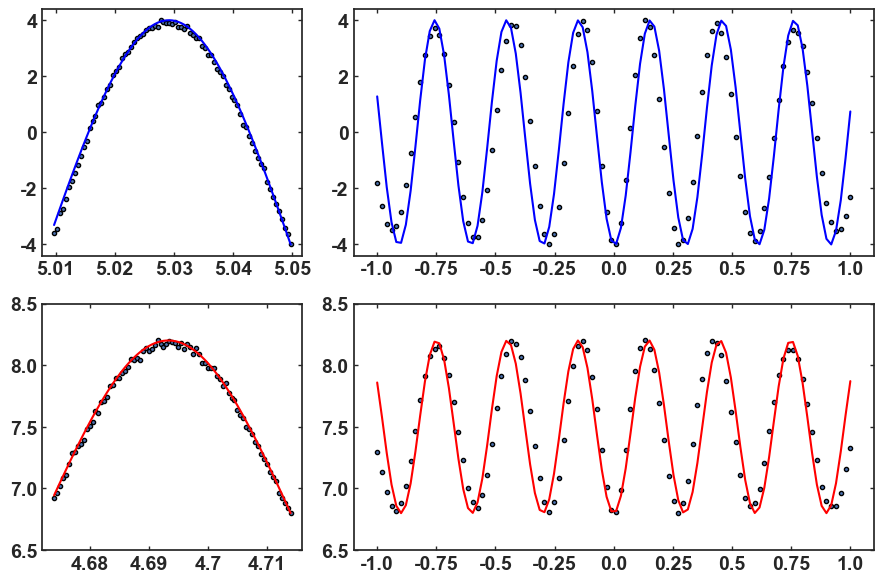

In [8]:
# plt.style.use('tmp/rose-pine-moon.mplstyle')
sns.set(style="white")
# Scaler TR01
scaler01 = MinMaxScaler(feature_range=(-4, 4))
y_tr01_reshaped = np.array(tr01_data.IQ_data).reshape(-1, 1)
y_tr01_normalized = scaler01.fit_transform(y_tr01_reshaped)
tr01_fit_reshaped = np.array(tr01_fit).reshape(-1, 1)
tr01_fit_normalized = scaler01.fit_transform(tr01_fit_reshaped)

# Scaler RR01
y_rr01_reshaped = np.array(rr01_data.IQ_data).reshape(-1, 1)
y_rr01_normalized = scaler01.fit_transform(y_rr01_reshaped)
rr01_fit_reshaped = np.array(rr01_fit).reshape(-1, 1)
rr01_fit_normalized = scaler01.fit_transform(rr01_fit_reshaped)

# Scaler TR12
scaler12 = MinMaxScaler(feature_range=(6.8, 8.2))
y_tr12_reshaped = np.array(tr12_data.IQ_data).reshape(-1, 1)
y_tr12_normalized = scaler12.fit_transform(y_tr12_reshaped)
tr12_fit_reshaped = np.array(tr12_fit).reshape(-1, 1)
tr12_fit_normalized = scaler12.fit_transform(tr12_fit_reshaped)

# Scaler RR12
y_rr12_reshaped = np.array(rr12_data.IQ_data).reshape(-1, 1)
y_rr12_normalized = scaler12.fit_transform(y_rr12_reshaped)
rr12_fit_reshaped = np.array(rr12_fit).reshape(-1, 1)
rr12_fit_normalized = scaler12.fit_transform(rr12_fit_reshaped)

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 2]},
                        figsize=(9, 6))

# Plot scatters
# TR01
axs[0, 0].scatter(x=frequencies_01_GHz, y=y_tr01_normalized, marker='.',
                  edgecolors='black')
axs[0, 0].plot(frequencies_01_GHz, tr01_fit_normalized, color='blue')
axs[0, 0].set_xticks([5.01, 5.02, 5.03, 5.04, 5.05])
axs[0, 0].set_yticks([4, 2, 0, -2, -4])
axs[0, 0].set_xticklabels([5.01, 5.02, 5.03, 5.04, 5.05], fontweight='bold')
axs[0, 0].set_yticklabels([4, 2, 0, -2, -4], fontweight='bold')
axs[0, 0].tick_params(direction='in', top=True, right=True,
                      bottom=True, left=True, length=3, width=1,
                      labelsize=14)
# RR01
axs[0, 1].scatter(x=amp01_sweeping_range, y=y_rr01_normalized, marker='.',
                  edgecolors='black')
axs[0, 1].plot(amp01_sweeping_range, rr01_fit_normalized, color='blue')
axs[0, 1].set_yticks([4, 2, 0, -2, -4])
axs[0, 1].set_xticks([-1., -0.75, -0.25, -0.50, 0., 0.25, 0.50, 0.75, 1.])
axs[0, 1].set_xticklabels([-1., -0.75, -0.25, -0.50, 0., 0.25, 0.50, 0.75, 1.], fontweight='bold')
axs[0, 1].set_yticklabels([4, 2, 0, -2, -4], fontweight='bold')
axs[0, 1].tick_params(direction='in', top=True, right=True,
                      bottom=True, left=True, length=3, width=1,
                      labelsize=14)
# TR12
axs[1, 0].scatter(x=frequencies_12_GHz, y=y_tr12_normalized, marker='.',
                  edgecolors='black')
axs[1, 0].plot(frequencies_12_GHz, tr12_fit_normalized, color='red')
axs[1, 0].set_yticks([6.5, 7.0, 7.5, 8.0, 8.5])
axs[1, 0].set_xticks([4.68, 4.69, 4.70, 4.71])
axs[1, 0].set_xticklabels([4.68, 4.69, 4.70, 4.71], fontweight='bold')
axs[1, 0].set_yticklabels([6.5, 7.0, 7.5, 8.0, 8.5], fontweight='bold')
axs[1, 0].tick_params(direction='in', top=True, right=True,
                      bottom=True, left=True, length=3, width=1,
                      labelsize=14)
# RR12
axs[1, 1].scatter(x=amp01_sweeping_range, y=y_rr12_normalized, marker='.',
                  edgecolors='black')
axs[1, 1].plot(amp01_sweeping_range, rr12_fit_normalized, color='red')
axs[1, 1].set_yticks([6.5, 7.0, 7.5, 8.0, 8.5])
axs[1, 1].set_xticks([-1., -0.75, -0.25, -0.50, 0., 0.25, 0.50, 0.75, 1.])
axs[1, 1].set_xticklabels([-1., -0.75, -0.25, -0.50, 0., 0.25, 0.50, 0.75, 1.], fontweight='bold')
axs[1, 1].set_yticklabels([6.5, 7.0, 7.5, 8.0, 8.5], fontweight='bold')
axs[1, 1].tick_params(direction='in', top=True, right=True,
                      bottom=True, left=True, length=3, width=1,
                      labelsize=14)

fig.tight_layout()
plt.savefig('output/TR + RR IBM_Lima test.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()

# Discriminator

In [9]:
omega01_ramsey = rough_frequency_01 * GHz + (4 - 3.2160804020100504) * MHz
omega12_ramsey = rough_frequency_12 * GHz + (5 - (5.2612 + 4.5226) / 2) * MHz
with pulse.build(backend=backend) as delay_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.delay(22496, drive_chan)

delay_gate = Gate('5mus_delay', 1, [])

In [12]:
ground_state_prep = QuantumCircuit(num_qubit, num_cbit)
ground_state_prep.append(delay_gate, [qubit])
ground_state_prep.add_calibration(delay_gate, [qubit], delay_sched)
ground_state_prep.measure(qubit, cbit)

first_excited_state_prep = QuantumCircuit(num_qubit, num_cbit)
first_excited_state_prep.append(delay_gate, [qubit])
first_excited_state_prep.add_calibration(delay_gate, [qubit], delay_sched)
first_excited_state_prep.x(qubit)
first_excited_state_prep.measure(qubit, cbit)

x12 = Gate('X12', 1, [])
with pulse.build(backend=backend) as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(omega12_ramsey, drive_chan)
    pulse.play(pulse.Gaussian(duration=144, sigma=144 / 4, amp=x_amp_12), drive_chan)

second_excited_state_prep = QuantumCircuit(num_qubit, num_cbit)
second_excited_state_prep.append(delay_gate, [qubit])
second_excited_state_prep.add_calibration(delay_gate, [qubit], delay_sched)
second_excited_state_prep.x(qubit)
second_excited_state_prep.append(x12, [qubit])
second_excited_state_prep.add_calibration(x12, [qubit], x12_sched)
second_excited_state_prep.measure(qubit, cbit)

discrim_package = [ground_state_prep, first_excited_state_prep, second_excited_state_prep]

In [13]:
discriminator_job = execute(experiments=discrim_package,
                            backend=backend,
                            shots=default_num_shots,
                            meas_return='single',
                            meas_level=1)
print(discriminator_job.job_id())
job_monitor(discriminator_job)

ci423ksoir23fnmm28r0
Job Status: job has successfully run                          


# Plot discriminator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

KeyboardInterrupt



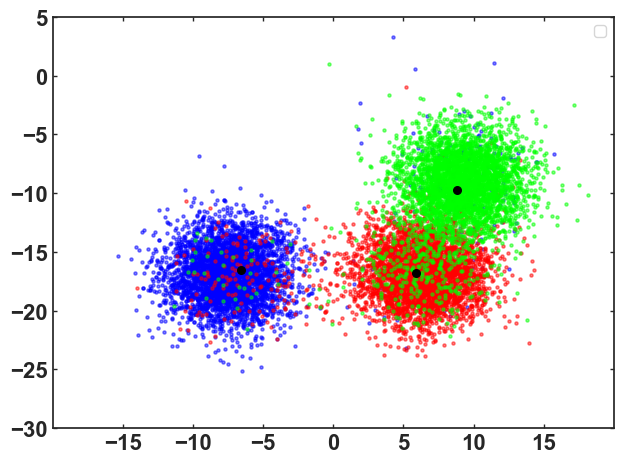

In [11]:
discriminator_job = provider.retrieve_job('ci423ksoir23fnmm28r0')
exp_results = discriminator_job.result(timeout=120)
iq_data = []
SCALE = QubitParameters.SCALE_FACTOR.value
for i in range(len(exp_results.results)):
    iq_data.append(exp_results.get_memory(i)[:, 0] * SCALE)
zero_data = iq_data[0]
one_data = iq_data[1]
two_data = iq_data[2]
sns.set(style="white")
# state 0 plotted in blue
plt.scatter(np.real(zero_data), np.imag(zero_data),
            s=5, c='blue', alpha=0.5)
# state 1 plotted in red
plt.scatter(np.real(one_data), np.imag(one_data),
            s=5, c='red', alpha=0.5)
# state 2 plotted in green
plt.scatter(np.real(two_data), np.imag(two_data),
            s=5, c='lime', alpha=0.5)

# Plot a large dot for the average result of the 0, 1 and 2 states.
mean_zero = np.mean(zero_data)  # takes mean of both real and imaginary parts
mean_one = np.mean(one_data)
mean_two = np.mean(two_data)
plt.scatter(np.real(mean_zero), np.imag(mean_zero),
            s=30, cmap='viridis', c='black', alpha=1.0)
plt.scatter(np.real(mean_one), np.imag(mean_one),
            s=30, cmap='viridis', c='black', alpha=1.0)
plt.scatter(np.real(mean_two), np.imag(mean_two),
            s=30, cmap='viridis', c='black', alpha=1.0)
plt.tick_params(direction='in', top=True, right=True,
                      bottom=True, left=True, length=3, width=1)
plt.xlim(-20, 20)
plt.ylim(-30, 5)
plt.legend()
plt.xticks([-15, -10, -5, 0, 5, 10, 15], fontweight='bold')
plt.yticks([-30, -25, -20, -15, -10, -5, 0, 5], fontweight='bold')
plt.tick_params(labelsize=16)
plt.tight_layout()
# plt.ylabel('I [a.u.]', fontsize=15)
# plt.xlabel('Q [a.u.]', fontsize=15)
# plt.title("0-1-2 discrimination", fontsize=15)
plt.savefig("output/0 1 2 Discrimination IBM_Lima.png", dpi=9600, format='png')

D# Beta Leakage and the results

In [6]:
beta_leak01_job = provider.backend.retrieve_job('chthslpoq2qn3r1vh2h0')
leak01_data = DataAnalysis(beta_leak01_job, default_num_shots)
leak01_data.retrieve_data(average=False)
leak01_data.lda()
leak01_data.count_pop()
leak01_data.error_mitiq()

beta_leak12_job = provider.backend.retrieve_job('chtht0hoq2qn3r1vha6g')
leak12_data = DataAnalysis(beta_leak12_job, default_num_shots)
leak12_data.retrieve_data(average=False)
leak12_data.lda()
leak12_data.count_pop()
leak12_data.error_mitiq()

In [7]:
beta_range_sweep = np.linspace(-5, 5, 32)
print(len(leak01_data.mitiq_data))
print(len(leak01_data.mitiq_data[0]))

103
3


In [8]:
drag_values_n3_01 = leak01_data.mitiq_data[3:35, 0]
drag_values_n5_01 = leak01_data.mitiq_data[35:67, 0]
drag_values_n7_01 = leak01_data.mitiq_data[67:99, 0]

drag_values_n3_12 = leak12_data.mitiq_data[3:35, 1]
drag_values_n5_12 = leak12_data.mitiq_data[35:67, 1]
drag_values_n7_12 = leak12_data.mitiq_data[67:99, 1]

pi = np.pi

fit_params_n3_01, y_fit_n3_01 = fit_function(beta_range_sweep,
                                             drag_values_n3_01,
                                             lambda x, A, B, T, phi: A * np.cos((2 * pi / T) * x + phi) + B,
                                             [1, 0, 10, 0])

fit_params_n5_01, y_fit_n5_01 = fit_function(beta_range_sweep,
                                             drag_values_n5_01,
                                             lambda x, A, B, T, phi: A * np.cos((2 * pi / T) * x + phi) + B,
                                             [1, 0, 5, 0])

fit_params_n7_01, y_fit_n7_01 = fit_function(beta_range_sweep,
                                             drag_values_n7_01,
                                             lambda x, A, B, T, phi: A * np.cos((2 * pi / T) * x + phi) + B,
                                             [1, 0, 4, 0])

fit_params_n3_12, y_fit_n3_12 = fit_function(beta_range_sweep,
                                             drag_values_n3_12,
                                             lambda x, A, B, T, phi: A * np.cos((2 * pi / T) * x + phi) + B,
                                             [1, 0, 10, 0])

fit_params_n5_12, y_fit_n5_12 = fit_function(beta_range_sweep,
                                             drag_values_n5_12,
                                             lambda x, A, B, T, phi: A * np.cos((2 * pi / T) * x + phi) + B,
                                             [1, 0, 5, 0])

fit_params_n7_12, y_fit_n7_12 = fit_function(beta_range_sweep,
                                             drag_values_n7_12,
                                             lambda x, A, B, T, phi: A * np.cos((2 * pi / T) * x + phi) + B,
                                             [1, 0, 4, 0])


# Plot Leakage

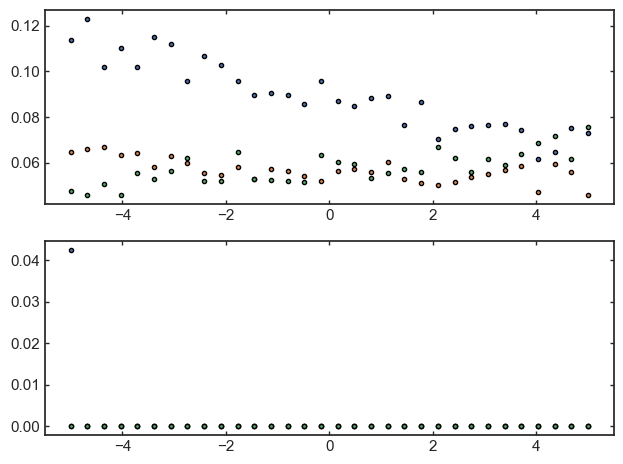

In [9]:
sns.set(style="white")
fig_leak, axs_leak = plt.subplots(2, 1)

# Plot scatters
# Leakage 01
axs_leak[0].scatter(x=beta_range_sweep, y=drag_values_n3_01,
                    marker='.', edgecolors='black')
# axs_leak[0].plot(beta_range_sweep, y_fit_n3_01, color='red')
axs_leak[0].scatter(x=beta_range_sweep, y=drag_values_n5_01,
                    marker='.', edgecolors='black')
# axs_leak[0].plot(beta_range_sweep, y_fit_n5_01, color='blue')
axs_leak[0].scatter(x=beta_range_sweep, y=drag_values_n7_01,
                    marker='.', edgecolors='black')
# axs_leak[0].plot(beta_range_sweep, y_fit_n7_01, color='green')
# axs_leak[0].axvline(0, color='black')
# axs_leak[0].axhline(1, color='black')
axs_leak[0].tick_params(direction='in', top=True, right=True,
                        bottom=True, left=True, length=3, width=1)
# Leakage 12
axs_leak[1].scatter(x=beta_range_sweep, y=drag_values_n3_12,
                    marker='.', edgecolors='black')
# axs_leak[1,].plot(beta_range_sweep, y_fit_n3_12, color='red')
axs_leak[1].scatter(x=beta_range_sweep, y=drag_values_n5_12,
                    marker='.', edgecolors='black')
# axs_leak[1].plot(beta_range_sweep, y_fit_n5_12, color='blue')
axs_leak[1].scatter(x=beta_range_sweep, y=drag_values_n7_12,
                    marker='.', edgecolors='black')
# axs_leak[1].plot(beta_range_sweep, y_fit_n7_12, color='green')
# axs_leak[1].axvline(0, color='black')
# axs_leak[1].axhline(1, color='black')
axs_leak[1].tick_params(direction='in', top=True, right=True,
                        bottom=True, left=True, length=3, width=1)
plt.tight_layout()

plt.savefig('output/Leakage Lima .svg', format='svg', dpi=1200, bbox_inches='tight')